In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [3]:
import os
import numpy as np
import pandas as pd
import pickle

In [4]:
test_list=os.listdir('../input/dermnet/test') 
#len test_list 
train_list=os.listdir('../input/dermnet/train')
#len(train_list) 23

#SORTING THEM FOR REFERENCE
train_list.sort()
test_list.sort()
#viewing items
#test_list[0:5]

print(train_list)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '../input/dermnet/test'

In [4]:
train_list_mod=['Acne and Rosacea Photos', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Atopic Dermatitis Photos', 'Eczema Photos', 'Nail Fungus and other Nail Disease', 'Psoriasis pictures Lichen Planus and related diseases']

In [5]:
len(train_list_mod)

6

In [6]:
def data_dictionary():
    path_train="../input/dermnet/train/"
    path_test="../input/dermnet/test/"
    list_train=train_list_mod#os.listdir(path_train)
    train_dictionary={"image_path":[],"target":[]}
    test_dictionary={"image_path":[],"target":[]}
    k=0
    for i in list_train:
        path_disease_train=path_train+i
        path_disease_test=path_test+i
        image_list_train=os.listdir(path_disease_train)
        image_list_test=os.listdir(path_disease_test)
        for j in image_list_train:
            img_path_train=path_disease_train+"/"+j
            train_dictionary["image_path"].append(img_path_train)
            train_dictionary['target'].append(k) 
        for m in image_list_test :
            img_path_test=path_disease_test+"/"+m
            test_dictionary["image_path"].append(img_path_test)
            test_dictionary['target'].append(k)
        k+=1 
    test_df=pd.DataFrame(test_dictionary)
    train_df=pd.DataFrame(train_dictionary)
        
    return  train_df,test_df

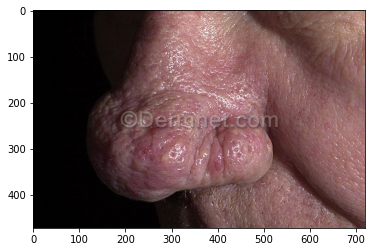

In [7]:
img=Image.open("../input/dermnet/test/Acne and Rosacea Photos/07Rhinophyma1.jpg")
plt.imshow(img)

In [8]:
def load_data(input_size=(100,100)):
    images=[]
    images2=[]
    train_df,test_df=data_dictionary()
    for i in train_df['image_path']:
        img=cv2.imread(i)
        img=cv2.resize(img,input_size)
        images.append(img)
    y_train=np.asarray(train_df['target'])
    x_train=np.asarray(images)
    for i in test_df['image_path']:
        img=cv2.imread(i)
        img=cv2.resize(img,input_size)
        images2.append(img)
    y_test=np.asarray(test_df['target'])
    x_test=np.asarray(images2)
    return x_train,x_test,y_train,y_test



In [9]:
x_train,x_test,y_train,y_test=load_data(input_size=(100,100))

In [10]:
from tensorflow.keras.applications import  VGG19
from tensorflow.keras.models import Model
from keras.applications.vgg19 import preprocess_input


In [5]:
vgg16 = VGG19(include_top=False,weights='imagenet')

NameError: name 'VGG19' is not defined

In [12]:
vgg16.summary()


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [13]:
import joblib

In [14]:
filename="vgg16.sav"
joblib.dump(vgg16,open(filename,'wb'))

In [15]:
vgg19=joblib.load("vgg16.sav")

In [16]:
train_img=preprocess_input(x_train)
test_img=preprocess_input(x_test)

In [17]:
features_train=vgg16.predict(train_img)

2022-09-28 21:44:54.296681: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-28 21:44:55.320478: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


In [18]:
features_test=vgg16.predict(test_img)

In [19]:
features_train.shape

(6158, 3, 3, 512)

In [20]:
features_test.shape

(1645, 3, 3, 512)

In [21]:
num_train=x_train.shape[0]
num_test=x_test.shape[0]


In [22]:
x_train=features_train.reshape(num_train,4608)
x_test=features_test.reshape(num_test,4608)

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense

In [24]:
model=Sequential([ Dense(1024,activation='relu'),
                   Dense(512,activation='relu'),
                  Dense(256,activation='relu'),
                  Dense(128,activation='relu'),
                  Dense(6,activation='sigmoid'),

])

In [25]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

In [26]:
model.fit(x_train,y_train,batch_size=32,epochs=40,validation_data=(x_test,y_test))

Epoch 1/40
193/193 [==============================] - 1s 4ms/step - loss: 1.8203 - accuracy: 0.4987 - val_loss: 1.1370 - val_accuracy: 0.5726
Epoch 2/40
193/193 [==============================] - 1s 3ms/step - loss: 0.8337 - accuracy: 0.6963 - val_loss: 1.0574 - val_accuracy: 0.6286
Epoch 3/40
193/193 [==============================] - 1s 3ms/step - loss: 0.5614 - accuracy: 0.7988 - val_loss: 1.1509 - val_accuracy: 0.6328
Epoch 4/40
193/193 [==============================] - 1s 3ms/step - loss: 0.3923 - accuracy: 0.8613 - val_loss: 1.2618 - val_accuracy: 0.6486
Epoch 5/40
193/193 [==============================] - 1s 3ms/step - loss: 0.2812 - accuracy: 0.9071 - val_loss: 1.3089 - val_accuracy: 0.6632
Epoch 6/40
193/193 [==============================] - 1s 3ms/step - loss: 0.2360 - accuracy: 0.9216 - val_loss: 1.3783 - val_accuracy: 0.6626
Epoch 7/40
193/193 [==============================] - 1s 3ms/step - loss: 0.2265 - accuracy: 0.9219 - val_loss: 1.2926 - val_accuracy: 0.6766
Epoch 

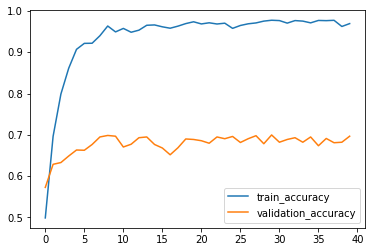

In [27]:
plt.plot(model.history.history['accuracy'],label="train_accuracy")
plt.plot(model.history.history['val_accuracy'],label="validation_accuracy")
plt.legend()
plt.show()


In [28]:
    
def load_img(img_path):
    images=[]
    img=cv2.imread(img_path)
    img=cv2.resize(img,(100,100))
    images.append(img)
    x_test=np.asarray(images)
    test_img=preprocess_input(x_test)
    features_test=vgg16.predict(test_img)
    num_test=x_test.shape[0]
    f_img=features_test.reshape(num_test,4608)
    
    return f_img
    

In [29]:
img=load_img("../input/dermnet/test/Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions/actinic-cheilitis-sq-cell-lip-20.jpg")

In [30]:
np.argmax(model.predict(img))

5

In [31]:
import pickle

In [32]:
!mkdir -p saved_model
model.save('saved_model/skin_model')

2022-09-28 21:45:51.451896: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [33]:
#filename="skin_model.pkl"
#joblib.dump(model,open(filename,'wb'))

In [34]:
new_model = tf.keras.models.load_model('saved_model/skin_model')

# Check its architecture
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              4719616   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 774       
Total params: 5,409,414
Trainable params: 5,409,414
Non-trainable params: 0
_________________________________________________________________


In [35]:
np.argmax(new_model.predict(img))

5